In [1]:
from qutip import *

from scipy.optimize import curve_fit as cf

import numpy as np
from numpy import pi as pi
from numpy import sqrt as sqrt

import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

In [2]:
def Rs(t,p):
    t = t/180*np.pi
    p = p/180*np.pi
    return np.array([np.sin(t)*np.cos(p), np.sin(t)*np.sin(p), np.cos(t)])    

def Rx(tx):
    tx = tx/180*np.pi
    Rx = np.array([[1,0,0],
                   [0,np.cos(tx),-np.sin(tx)],
                   [0,np.sin(tx), np.cos(tx)]])
    return Rx

def Rz(tz):
    tz= tz/180*np.pi
    Rz = np.array([[np.cos(tz), -np.sin(tz), 0],
                   [np.sin(tz), np.cos(tz), 0],
                   [0, 0, 1]])    
    return Rz

def Eigenbasis_Expansion(H):
    Q = np.zeros(H.shape, dtype=np.complex)
    for i, ev in enumerate(H.eigenstates()[1]):    
        Q[:,i] = ev.full().flatten()    
    return Q

In [3]:
def boltzmann(E, T):
    h = 6.626e-34
    kB = 1.38e-23
    return np.exp(-h*E/(kB*T))

def coth(gs, T):
    h = 6.626e-34
    kB = 1.38e-23
    return np.tanh(h*gs*1e9/(2*kB*T))**(-1)

def lorentzian(nu, nu0, Gamma, A, c):
    return A*(Gamma/2)**2/((nu-nu0)**2+(Gamma/2)**2) + c 

def gaussian(nu, nu0, sigma, A, c):
    return A*1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(nu-nu0)**2/(2*sigma**2)) + c

def pulse_seq(t, width, t0=0, tau=0, N=1):
    seq = np.zeros(t.shape)
    starts = []
    stops = []
    for n in range(N):
        starts.append(t0)
        stops.append(t0+width)
        seq += np.where( (t>=t0)&(t<t0+width), 1, 0)        
        t0 = t0 + width
        t0 += (n+1)*tau
    
    starts = np.array(starts)
    stops = np.array(stops)
    return starts, stops, seq

In [334]:
h = 6.626e-34
c = 299792458
e = 1.62e-19
T = 5

# Bare coulomb splitting of Eg and Eu states
w_C = 2*pi*c/736.85

# Spin-orbit couplings
lbd_SO_g = 2*pi*40
lbd_SO_u = 2*pi*250

# (Transverse) Strain couplings
alpha_g = 2*pi*30
beta_g = 2*pi*10

alpha_u = 2*pi*1.8/1.3*alpha_g
beta_u = 2*pi*2*beta_g

# Magnetons and gyromagnetic ratio for electron and nuclear spin
muB = 2*pi*9.274e-24/h * 1e-9
muN = 2*pi*5.505e-23/h * 1e-9
g_e = 2
g_n = 1.910

# Orbital angular momentum quenching factor (phenomenological)
q = 0.1

# Nuclear spin coupling strengths along and perpendicular to the electron spin quantization axis 
# (which might be different from the SiV symmmetry axis)
A_para = 0*50e-1
A_perp = 0*100e-2

# SiV orientation (theta, phi) with respect to external lab frame, where z defines the optical axis
# theta_x = 54.7 and theta_z = 45 corresponds to a <111> crystal direction
theta_x = 54.7
theta_z = 45

# We can use a transformation matrix which transforms coordinates such that 111 --> 001, i.e. in this reference
# frame the SiV symmetry axis is pointing along z
Rz(-theta_z)@Rx(-theta_x)

array([[ 0.70710678,  0.40860704,  0.57709642],
       [-0.70710678,  0.40860704,  0.57709642],
       [ 0.        , -0.81613759,  0.57785762]])

In [335]:
egx = basis(4, 0)
egy = basis(4, 1)
eux = basis(4, 2)
euy = basis(4, 3)

sgx = egx*egy.dag()
sgx += sgx.dag()
sgy = -1j*egx*egy.dag()
sgy += sgy.dag()
sgz = egx*egx.dag() - egy*egy.dag()
sux = eux*euy.dag()
sux += sux.dag()
suy = -1j*eux*euy.dag()
suy += suy.dag()
suz = eux*eux.dag() - euy*euy.dag()

egp = 1/np.sqrt(2)*(egx + 1j*egy)
egm = 1/np.sqrt(2)*(egx - 1j*egy)
eup = 1/np.sqrt(2)*(eux + 1j*euy)
eum = 1/np.sqrt(2)*(eux - 1j*euy)
sigm_x = egp*eum.dag() + egm*eup.dag()
sigm_y = 1j*egp*eum.dag() -1j* egm*eup.dag()
sigm_z = 2*(egp*eup.dag() + egm*eum.dag())
px = sigm_x+sigm_x.dag()
py = sigm_y+sigm_y.dag()
pz = sigm_z+sigm_z.dag()

In [336]:
su = basis(2,0)
sd = basis(2,1)
Sx = su*sd.dag() + sd*su.dag()
Sy = -1j*su*sd.dag() + 1j*sd*su.dag()
Sz = su*su.dag() - sd*sd.dag()

In [337]:
Iu = basis(2,0)
Id = basis(2,1)
Ix = Iu*Id.dag() + Id*Iu.dag()
Iy = -1j*Iu*Id.dag() + 1j*Id*Iu.dag()
Iz = Iu*Iu.dag() - Id*Id.dag()

In [338]:
sgx = tensor(sgx, qeye(2))
sgy = tensor(sgy, qeye(2))
sgz = tensor(sgz, qeye(2))
sux = tensor(sux, qeye(2))
suy = tensor(suy, qeye(2))
suz = tensor(suz, qeye(2))
sigm_x = tensor(sigm_x, qeye(2))
sigm_y = tensor(sigm_y, qeye(2))
sigm_z = tensor(sigm_z, qeye(2))
px = tensor(px, qeye(2))
py = tensor(py, qeye(2))
pz = tensor(pz, qeye(2))

Sx = tensor(qeye(4), Sx)
Sy = tensor(qeye(4), Sy)
Sz = tensor(qeye(4), Sz)

In [339]:
if max(A_para, A_perp)>0:
    sgx = tensor(sgx, qeye(2))
    sgy = tensor(sgy, qeye(2))
    sgz = tensor(sgz, qeye(2))
    sux = tensor(sux, qeye(2))
    suy = tensor(suy, qeye(2))
    suz = tensor(suz, qeye(2))
    px = tensor(px, qeye(2))
    py = tensor(py, qeye(2))
    pz = tensor(pz, qeye(2))
    
    Sx = tensor(Sx, qeye(2))
    Sy = tensor(Sy, qeye(2))
    Sz = tensor(Sz, qeye(2))
    
    Ix = tensor(qeye(4), qeye(2), Ix)
    Iy = tensor(qeye(4), qeye(2), Iy)
    Iz = tensor(qeye(4), qeye(2), Iz)

In [340]:
HC = w_C/2*tensor(eux*eux.dag() + euy*euy.dag() - egx*egx.dag() - egy*egy.dag(), qeye(2))

B = 0.13
bx, by, bz = Rx(theta_x)@Rz(theta_z)@Rs(54.7+9, 50)
Bx = B*bx
By = B*by
Bz = B*bz 

HSO = lbd_SO_g/2 * sgy * Sz + lbd_SO_u/2 * suy * Sz

HZS = g_e * muB/2 * (Sx * Bx + Sy * By + Sz * Bz)
HZL = muB * (-sgy - suy) * Bz

HStr = alpha_g*sgz + beta_g*sgx + alpha_u*suz + beta_g*sux

H = HC + HSO + HZS + HZL + HStr

if max(A_para, A_perp)>0:
    HZN = g_n * muN/2 * (Ix * Bx + Iy * By + Iz * Bz)
    HHF = A_para * Sz*Iz + A_perp*(Sx*Ix + Sy*Iy)
    H += HZN + HHF

H = H.tidyup(1e-10)

engs = H.eigenstates()[0]     
evs = H.eigenstates()[1]     

    
gs = 0.5 * abs((tensor(egm.dag(), su.dag())*H*tensor(egm, su) - tensor(egp.dag(), su.dag())*H*tensor(egp, su))[0,0])
gs += 0.5 * abs((tensor(egp.dag(), sd.dag())*H*tensor(egp, sd) - tensor(egm.dag(), sd.dag())*H*tensor(egm, sd))[0,0])
gs /= 2*pi
print("Groundstate splitting: ", gs)
es = 0.5 * abs((tensor(eum.dag(), su.dag())*H*tensor(eum, su) - tensor(eup.dag(), su.dag())*H*tensor(eup, su))[0,0])
es += 0.5 * abs((tensor(eup.dag(), sd.dag())*H*tensor(eup, sd) - tensor(eum.dag(), sd.dag())*H*tensor(eum, sd))[0,0])
es /= 2*pi
print("Excited state splitting: ", es)

print("5-4 Splitting: ", (engs[5] - engs[4])/(2*pi))
print("3-2 Splitting: ", (engs[3] - engs[2])/(2*pi))
print("1-0 Splitting: ", (engs[1] - engs[0])/(2*pi))
print("2-0 Splitting: ", (engs[2] - engs[0])/(2*pi))

Groundstate splitting:  40.00000000000884
Excited state splitting:  250.0000000000182
5-4 Splitting:  5.162711470572273
3-2 Splitting:  1.7527786156392273
1-0 Splitting:  5.524060742935602
2-0 Splitting:  76.78086752879935


In [295]:
print((tensor(egp.dag(), su.dag())*H*tensor(egp, su) - tensor(egm.dag(), su.dag())*H*tensor(egm, su))/(2*pi))
print((tensor(egp.dag(), sd.dag())*H*tensor(egp, sd) - tensor(egm.dag(), sd.dag())*H*tensor(egm, sd))/(2*pi))
print((tensor(egm.dag(), su.dag())*H*tensor(egm, su) - tensor(egp.dag(), su.dag())*H*tensor(egp, su))/(2*pi))
print((tensor(egm.dag(), sd.dag())*H*tensor(egm, sd) - tensor(egp.dag(), sd.dag())*H*tensor(egp, sd))/(2*pi))

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[36.2536541]]
Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-43.7463459]]
Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-36.2536541]]
Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[43.7463459]]


In [296]:
Gamma_opt = 1/(2*pi*1.73)
Gamma_phon_g0 = 1/(2*pi*40)
Gamma_phon_u0 = 1/(2*pi*0.40)
Gamma_espin = 1/(2*pi*1e3)

Gamma_nspin = 1/(2*pi*1e6)

c_ops = []

# Optical decays defined from SO basis (only Emission relevant)
c_ops.append(np.sqrt(Gamma_opt)*sigm_x)
c_ops.append(np.sqrt(Gamma_opt)*sigm_y)
c_ops.append(np.sqrt(Gamma_opt)*sigm_z)

# Phononic relaxation
# Emission
c_ops.append(np.sqrt(1/(boltzmann(gs*1e9, T)+1)*Gamma_phon_g0) * (tensor(egp*egm.dag(),su*su.dag()) + tensor(egm*egp.dag(), sd*sd.dag())))
c_ops.append(np.sqrt(1/(boltzmann(es*1e9, T)+1)*Gamma_phon_u0) * (tensor(eup*eum.dag(),su*su.dag()) + tensor(eum*eup.dag(), sd*sd.dag())))

# Absorption
c_ops.append(np.sqrt(boltzmann(gs*1e9, T)/(boltzmann(gs*1e9, T)+1)*Gamma_phon_g0) * (tensor(egp*egm.dag(),sd*sd.dag()) + tensor(egm*egp.dag(),su*su.dag())))
c_ops.append(np.sqrt(boltzmann(es*1e9, T)/(boltzmann(es*1e9, T)+1)*Gamma_phon_u0) * (tensor(eup*eum.dag(),sd*sd.dag()) + tensor(eum*eup.dag(),su*su.dag())))

#Spin relaxation
# c_ops.append(np.sqrt(Gamma_spin)*tensor(egm*egp.dag() + egp*egm.dag() + eum*eup.dag() + eup*eum.dag(), sd*su.dag()))
# c_ops.append(np.sqrt(Gamma_spin)*tensor(egp*egm.dag() + egm*egp.dag() + eum*eup.dag() + eup*eum.dag(), su*sd.dag())) 
c_ops.append(np.sqrt(Gamma_espin)*tensor(qeye(4), sd*su.dag()))
c_ops.append(np.sqrt(Gamma_espin)*tensor(qeye(4), su*sd.dag()))

In [342]:
trans_engs = np.zeros(H.shape)
trans_dipoles = np.zeros(H.shape)

engs_ = H.eigenstates()[0]
evs_ = H.eigenstates()[1]

for i, engi in enumerate(engs_):
    for j, engj in enumerate(engs_[:i]):         
        if round(abs(engi-engj),3)<1e4: continue
        trans_engs[i,j] = abs(engi-engj)
        trans_dipoles[i,j] = abs((evs_[i].dag() * px * evs_[j])[0,0])**2 + abs((evs_[i].dag() * py * evs_[j])[0,0])**2 + abs((evs_[i].dag() * pz * evs_[j])[0,0])**2

# transitions = list(sorted(set(trans_engs[trans_engs.nonzero()])))
transitions = np.array(list(sorted(trans_engs[trans_engs.nonzero()])))

D = transitions[0*len(transitions)//4:1*len(transitions)//4]
C = transitions[1*len(transitions)//4:2*len(transitions)//4]
B = transitions[2*len(transitions)//4:3*len(transitions)//4]
A = transitions[3*len(transitions)//4:4*len(transitions)//4]

In [343]:
C/(2*pi)

array([406599.37730724, 406604.54001871, 406604.90136799, 406610.06407946])

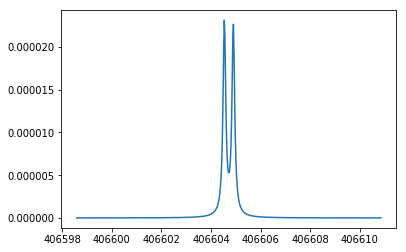

In [344]:
Omega_L1 = 1*Gamma_opt
Omega_L2 = 0.05*Gamma_opt
eps_x, eps_y, eps_z = Rx(theta_x)@Rz(theta_z)@Rs(54.7+45,45)


delta2 = 0
deltas = np.linspace(-50*Gamma_opt, 50*Gamma_opt, 500)
w_Ls = np.linspace(-5+min(C), max(C)+5, 500)
w_L1 = C[0]

pops_tot = np.zeros_like(w_Ls)
for i, w_L2 in enumerate(w_Ls):  
# for i, w_L in enumerate(deltas):    
#     Hint = Omega_L1/2*(evs[0]*evs[8].dag() + evs[8]*evs[0].dag())
#     Hint += Omega_L2/2*(evs[3]*evs[8].dag() + evs[8]*evs[3].dag())
#     rho_ss = steadystate(Hint + delta2*evs[8]*evs[8].dag() + delta1*evs[3]*evs[3].dag(), c_ops)
    Hint = Omega_L2/2*(eps_x*px + eps_y*py + eps_z*pz) - w_L2/w_C * HC
    Hint = Hint.tidyup()
    
    rho_ss = steadystate(H+Hint, c_ops)
    pops_tot[i] = np.sum(rho_ss.diag()[4:])
#     pops_tot[i] = np.sum(np.real(np.diag(np.linalg.inv(Q)@(rho_ss.full())@Q))[4:])
#     pops_tot[i] = np.real(np.diag(np.linalg.inv(Q)@(rho_ss.full())@Q))[4]
plt.plot(w_Ls/(2*pi), pops_tot)

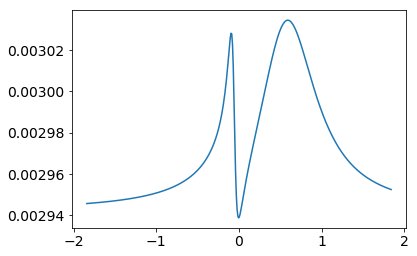

In [168]:
Omega_L1 = 5*Gamma_opt
Omega_L2 = 0.05*Gamma_opt

delta2 = 0.5
deltas = np.linspace(-20*Gamma_opt, 20*Gamma_opt, 400)
pops_tot = np.zeros_like(deltas)
for i, delta1 in enumerate(deltas):    
    Hint = Omega_L1/2*(evs[0]*evs[4].dag() + evs[4]*evs[0].dag())
    Hint += Omega_L2/2*(evs[1]*evs[4].dag() + evs[4]*evs[1].dag())
    
    rho_ss = steadystate(Hint + delta2*evs[4]*evs[4].dag() + delta1*evs[1]*evs[1].dag(), c_ops)
    pops_tot[i] = np.sum(np.real(np.diag(np.linalg.inv(Q)@(rho_ss.full())@Q))[4:])
#     pops_tot[i] = np.real(np.diag(np.linalg.inv(Q)@(rho_ss.full())@Q))[4]
plt.plot(deltas, pops_tot)